## Boston AirBnB open data with the CRISP-DM (Cross Industry Process for Data Mining)

To get general AirBnB business insight, the Boston data from AirBnB will be analyzed based on the CRISP-DM. The subprocesses of the CRISP-DM are written below.

`1`. Business Understanding

`2`. Data Understanding

`3`. Prepare Data

`4`. Data Modeling

`5`. Evaluate the Results

`6`. Deploy

In [662]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar #To check holidays in the U.S
import time


In [663]:
# Load the AirBnB files
df_listing = pd.read_csv('./listings.csv')
df_calendar = pd.read_csv('./calendar.csv')
df_reviews = pd.read_csv('./reviews.csv')

## 1. Business Understanding

Business Questions 
    - What are the most relevant features of the groups over the 90 percentile and under the 10 percentile?
    - What are the most relevant features to be cared for the two traveler group and more than four traveler group?
    - How is the price of AirBnb adjusted in terms of seasons and locations?

## 2. Data Understanding

Check and play around the dataframes loaded before to get some idea or to get the business quesations progressed.
### 2.1. For df_listing

In [664]:
pd.set_option('display.max_columns', None)  

In [665]:
print(df_listing.shape)
df_listing.head(n=7)
df_listing[['number_of_reviews', 'review_scores_rating']].head(n=30)
df_listing.number_of_reviews.isna().sum()

(3585, 95)


0

In [666]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

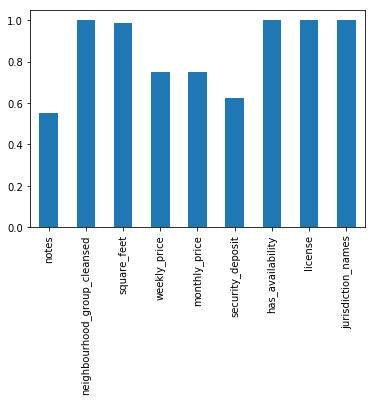

In [667]:
df_missing = df_listing.isna().mean()
df_missing[df_missing>0.5].plot.bar()

In [668]:
print("# of id:",df_listing.id.unique().size)
print("# of host_id:",df_listing.host_id.unique().size)
# There are some hosts who take care of more than two ids

# of id: 3585
# of host_id: 2181


# of accommodates: [ 4  2  3  5  1  8  6 16  7  9 10 12 11 14]
2     0.413668
4     0.181311
1     0.122455
3     0.119386
5     0.068340
6     0.056625
8     0.015342
7     0.010879
10    0.005300
9     0.002789
12    0.001395
11    0.001116
14    0.000837
16    0.000558
Name: accommodates, dtype: float64
Accomodates equal or less than 2 is 53.61 %
Accomodates more than 2 is 42.57 %


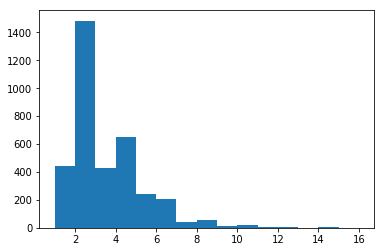

In [669]:
print("# of accommodates:",df_listing.accommodates.unique())
tmp = df_listing.accommodates.value_counts(ascending=False)/df_listing.accommodates.size
print(tmp)
print("Accomodates equal or less than 2 is {:5.2f} %".format((tmp[1]+tmp[2])*100))
print("Accomodates more than 2 is {:5.2f} %".format((tmp[3]+tmp[4]+tmp[5]+tmp[6])*100))
# 96% of total id can be categorized into the group with less than 2 people or the group with more than 2 people
plt.hist(df_listing.accommodates, bins=15)
plt.show()

In [670]:
print("# of bed_type:",df_listing.bed_type.unique())

# of bed_type: ['Real Bed' 'Pull-out Sofa' 'Futon' 'Airbed' 'Couch']


### 2.2. For df_calendar

(1308890, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
listing_id    1308890 non-null int64
date          1308890 non-null object
available     1308890 non-null object
price         643037 non-null object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB
None


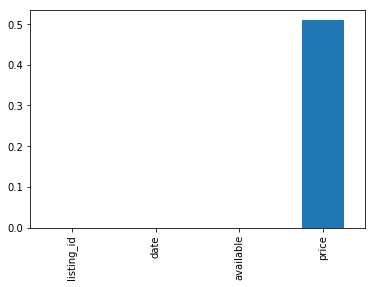

In [671]:
print(df_calendar.shape)
print(df_calendar.info())
df_calendar.head()
df_missing_calendar = df_calendar.isna().mean()
df_missing_calendar.plot.bar()

In [672]:
# Modify df_calendar for future work
# Special event : marathon, new academic season

def modify_calendar(df_calendar):
    '''
    This function creates 'year', 'month', 'day', 'weekday',  and 'week_number' columns from 'date' coulmn of df_calendar 
    and remove '$' string from 'price' coulmn.
    
    Input : a Pandas dataframe having a date data column
    Output : a Pandas dataframe having year, month, day, weekday, us_holiday columns
    '''
    # Split date column into year, month,day, weekday columns
    # The day of the week with Monday=0, Sunday=6
    # Set the range of weekends from Friday to Sunday
    df_calendar['year'] = pd.DatetimeIndex(df_calendar['date']).year
    df_calendar['month'] = pd.DatetimeIndex(df_calendar['date']).month
    df_calendar['day'] = pd.DatetimeIndex(df_calendar['date']).day
    df_calendar['weekday'] = pd.DatetimeIndex(df_calendar['date']).weekday
    df_calendar['week_number'] = pd.DatetimeIndex(df_calendar['date']).week
#     df_calendar['price'].replace(to_replace="\$([0-9,\.]+).*", value=r"\1", regex=True, inplace=True)
    df_calendar['price']= df_calendar['price'].str.replace('$','')
    df_calendar['price']=df_calendar['price'].str.replace(',','')
    df_calendar['price'] = df_calendar['price'].astype(float)
    
    # Add us_holiday column
    cal = calendar()
    holidays = cal.holidays(start=df_calendar.date.min(), end=df_calendar.date.max())
    df_calendar['us_holiday'] = df_calendar.date.astype('datetime64').isin(holidays)
    
    # Add weekend column #Friday, Saturday
    weekend = [4,5]
    df_calendar['weekend'] = df_calendar.weekday.isin(weekend)
    
    # Replace values in weekday column 
    df_calendar['weekday'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',4:'Friday', 5:'Saturday', 6:'Sunday'}, inplace=True)
    
    return df_calendar

In [673]:
# cal = calendar()
# holidays = cal.holidays(start=df_calendar.date.min(), end=df_calendar.date.max())
# print(holidays)
# print(holidays.dayofweek)
# print()
# print(pd.date_range(start='1/1/2018', periods=8))

In [674]:
df_cal_modified = modify_calendar(df_calendar)
print(df_cal_modified.shape[0]/365)
# df_cal_modified.tail(n=10)

# Each listing_id has 365 rows

3586.0


In [675]:
def add_availabledays_price(df_listing, df_cal_modified):
    '''
    This function creates columns of 'unavail_days', 'avail_days_weekends', 
    'avail_days_weekdays', 'price_weekend', and 'price_weekday' where calculated from df_cal_modified on df_listing.
    
    Input : 
    - A Pandas dataframe made from 'listings.csv' : df_listing
    - A pandas dataframe modified by modify_calendar() : df_cal_modified
    
    Output :
    - the modified df_listing dataframe with new 'unavail_days', 'avail_days_weekends',
    'avail_days_weekdays', 'price_weekend', and 'price_weekday' columns 
    '''
    id_list = df_listing.id[:]
    unavailable_days_array = np.array([])
    avail_days_weekends_array =  np.array([])
    avail_days_weekdays_array = np.array([])
    price_weekend_array = np.array([])
    price_weekday_array = np.array([])

    for i in np.nditer(id_list):
        tmp = df_cal_modified[(df_cal_modified.listing_id == i)] # Make a dataframe coming from df_listing with a certain id
        available_dict = tmp.available.value_counts().to_dict()
#         print(available_dict)
        if 'f' in available_dict:
            unavailable_days = tmp[tmp.available == 'f'].shape[0]
        else:
            unavailable_days = 0

        if 't' in available_dict:
            available_weekends = tmp[(tmp.available == 't') & (tmp.weekend == True)].shape[0]
            available_weekdays = tmp[(tmp.available == 't') & (tmp.weekend == False)].shape[0]
    #         print("available days:(weekends, weekdays)",available_weekends, available_weekdays)
            price_weekend = tmp[(tmp.weekend == True) & (tmp.available == 't')].price.astype(float).describe()['mean']
            price_weekday = tmp[(tmp.weekend == False) & (tmp.available == 't')].price.astype(float).describe()['mean']
    #         print("price:(weekends, weekdays)",price_weekend, price_weekday)

        else:
            available_weekends = 0
            available_weekdays = 0
            price_weekend = np.nan
            price_weekday = np.nan

#         print("unavailable days:", unavailable_days)
#         print("available days:(weekends, weekdays)", available_weekends, available_weekdays)
#         print("price:(weekends, weekdays)", price_weekend, price_weekday)
#         print("**"*30)

        unavailable_days_array = np.append(unavailable_days_array, unavailable_days)
        avail_days_weekends_array = np.append(avail_days_weekends_array, available_weekends)
        avail_days_weekdays_array = np.append(avail_days_weekdays_array, available_weekdays)
        price_weekend_array = np.append(price_weekend_array, price_weekend)
        price_weekday_array = np.append(price_weekday_array, price_weekday)
#         print(price_weekend_array)
#         print(price_weekday_array)
    df_listing['unavail_days'] = pd.Series(unavailable_days_array)
    df_listing['avail_days_weekends'] = pd.Series(avail_days_weekends_array)
    df_listing['avail_days_weekdays'] = pd.Series(avail_days_weekdays_array)
    df_listing['price_weekend'] = pd.Series(price_weekend_array)
    df_listing['price_weekday'] = pd.Series(price_weekday_array)



#     avail_weekday = df_cal_id[df_cal_id.weekend == False].available.value_counts()['t']  #count weekdays with available 't' 
#     avail_weekend = df_cal_id[df_cal_id.weekend == True].available.value_counts()['t'] #count weekends with available 't' 
#     price_weekday = df_cal_id[(df_cal_id.weekend == False) & (df_cal_id.available == 't')].price.astype(float).describe()['mean']
#     price_weekend = df_cal_id[(df_cal_id.weekend == True) & (df_cal_id.available == 't')].price.astype(float).describe()['mean']
    
#     print('unavail, avail_total,avail_weekday,avail_weekend', unavail,avail_total,avail_weekday,avail_weekend)
#     print("price_weekday","price_weekend",price_weekday,price_weekend)

In [676]:
start = time.time() 
add_availabledays_price(df_listing, df_cal_modified)
print("time :", time.time() - start)
df_listing.tail(n=10)

time : 52.53043603897095


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday
3575,5280827,https://www.airbnb.com/rooms/5280827,20160906204935,2016-09-07,Private cozy room,"Cozy room near T station. 5 min walking to T, ...",NaN,"Cozy room near T station. 5 min walking to T, ...",none,NaN,NaN,NaN,NaN,NaN,1. No damage to the house or furniture 2. No S...,https://a2.muscache.com/im/pictures/116bc87c-8...,https://a2.muscache.com/im/pictures/116bc87c-8...,https://a2.muscache.com/im/pictures/116bc87c-8...,https://a2.muscache.com/im/pictures/116bc87c-8...,19246369,https://www.airbnb.com/users/show/19246369,Joe,2014-07-31,"Somerville, Massachusetts, United States",NaN,within an hour,96%,100%,f,https://a2.muscache.com/im/users/19246369/prof...,https://a2.muscache.com/im/users/19246369/prof...,Somerville,28,28,"['email', 'phone', 'reviews', 'jumio']",t,t,"Washington Street, Somerville, MA 02143, Unite...",Somerville,Charlestown,NaN,Somerville,MA,02143,Boston,"Somerville, MA",US,United States,42.382681,-71.085720,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",NaN,$69.00,NaN,NaN,$95.00,NaN,1,$24.00,2,1125,a week ago,NaN,25,51,81,356,2016-09-06,6,2015-03-07,2016-08-20,70.0,8.0,7.0,9.0,10.0,8.0,7.0,f,NaN,NaN,t,strict,f,f,8,0.33,9.0,101.0,255.0,75.000000,69.000000
3576,14689681,https://www.airbnb.com/rooms/14689681,20160906204935,2016-09-07,Beautiful loft style bedroom with large bathroom,You'd be living on the top floor of a four sto...,NaN,You'd be living on the top floor of a four sto...,none,NaN,NaN,NaN,NaN,NaN,NaN,https://a2.muscache.com/im/pictures/725a70f0-a...,https://a2.muscache.com/im/pictures/725a70f0-a...,https://a2.muscache.com/im/pictures/725a70f0-a...,https://a2.muscache.com/im/pictures/725a70f0-a...,50546418,https://www.airbnb.com/users/show/50546418,Thomas,2015-12-04,"Somerville, Massachusetts, United States",NaN,within a day,100%,100%,f,https://a2.muscache.com/im/pictures/f44ebd43-8...,https://a2.muscache.com/im/pictures/f44ebd43-8...,Cambridge,1,1,"['email', 'phone', 'reviews', 'jumio']",t,t,"Putnam Avenue, Cambridge, MA 02139, United States",Cambridge,Allston,NaN,Cambridge,MA,02139,Boston,"Cambridge, MA",US,United States,42.365112,-71.114801,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Air Conditioning"",Kitchen,""Indoor Fireplace""...",NaN,$124.00,NaN,NaN,$200.00,$85.00,1,$0.00,2,1125,2 weeks ago,NaN,5,5,20,110,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,flexible,f,f,1,NaN,255.0,32.0,78.0,152.875000,131.820513
3577,13750763,https://www.airbnb.com/rooms

In [677]:
print(df_listing.shape)
df_listing.info()

(3585, 100)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 100 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url              

In [678]:
# 내가 원하는거 : 
## Available 't', 'f' 값 확인
## Available 't' 에서 주중t, 주말t 분리 후
## Available 주중t 의 평균 price, 주말t의 평균 price

tmp = df_cal_modified[(df_cal_modified.listing_id == 14504422)]
available_dict = tmp.available.value_counts().to_dict()
print(available_dict)
if 'f' in available_dict:
    print(tmp[tmp.available == 'f'].shape)
    unavailable_days = tmp[tmp.available == 'f'].shape[0]
    
if 't' in available_dict:
    print(tmp[tmp.available == 't'].shape)
    
    available_weekends = tmp[(tmp.available == 't') & (tmp.weekend == True)].shape[0]
    available_weekdays = tmp[(tmp.available == 't') & (tmp.weekend == False)].shape[0]
    print(available_weekends, available_weekdays)
    price_weekend = tmp[(tmp.weekend == True) & (tmp.available == 't')].price.astype(float).describe()['mean']
    price_weekday = tmp[(tmp.weekend == False) & (tmp.available == 't')].price.astype(float).describe()['mean']
    print(price_weekend, price_weekday)

# tmp1 = tmp.available.value_counts()
# print(len(tmp1))
# empty_list = []
# for i in range(len(tmp1)):
#     j = (tmp.available.value_counts().index[i], tmp.available.value_counts()[i])
#     empty_list.append(j)
    
# print(empty_list)


# price_weekday = tmp[(tmp.weekend == False) & (tmp.available == 't')].price.astype(float).describe()['mean']
# price_weekend = tmp[(tmp.weekend == True) & (tmp.available == 't')].price.astype(float).describe()['mean']
# print(price_weekday,price_weekend)


{'f': 200, 't': 165}
(200, 11)
(165, 11)
50 115
64.64 64.84347826086956


In [679]:
# print("Total available days of id 14504422:", df_cal_modified[(df_cal_modified.listing_id == 14504422) & (df_cal_modified.available == 't')].shape[0])
# print("Total unavailable days of id 14504422:", df_cal_modified[(df_cal_modified.listing_id == 14504422) & (df_cal_modified.available == 'f')].shape[0])
# print()
# print("Total available days of weekends or holidays of id 14504422:", df_cal_modified[(df_cal_modified.listing_id == 14504422) & (df_cal_modified.available == 't') 
#                                                                          & (df_cal_modified.weekend == True)].shape[0])
# print("Total available days of weekdays of id 14504422:", df_cal_modified[(df_cal_modified.listing_id == 14504422) & (df_cal_modified.available == 't') 
#                                                                          & (df_cal_modified.weekend == False)].shape[0])

In [680]:
# print("# of listing_id:", df_calendar.listing_id.unique().size)
# print(df_calendar.date.min())
# print(df_calendar.date.max())
# # The number of listing_id in df_calendar is 3585 as the same as the number of id in df_listing
# # df_calendar has one year data from 2016-09-06 to 2017-09-05
# # date column can be seprated into year, month, day, week, weekend, official holiday.

## 3. Prepare data

In [681]:
# Drop columns having 50% of nan value
tmp_df = df_missing[df_missing>0.5]
missing_over_50_list=  tmp_df.index.to_list()
df_listing_modi1 = df_listing.drop(missing_over_50_list, axis=1)
print(df_listing.shape)
print(df_listing_modi1.shape)

(3585, 100)
(3585, 91)


In [682]:
df_listing_modi1.head()
# Drop columns related with urls and irrelevant columns
remove_list1 = ['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 
                'host_thumbnail_url', 'host_picture_url', 'country_code', 'country']
df_listing_modi2 = df_listing_modi1.drop(remove_list1, axis=1)
df_listing_modi2.shape

(3585, 79)

In [683]:
df_listing_modi2

,id,name,summary,space,description,experiences_offered,neighborhood_overview,transit,access,interaction,house_rules,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday
0,12147973,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...","The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,MA,02131,Boston,"Boston, MA",42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,$35.00,1,$0.00,2,1125,2 weeks ago,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,moderate,f,f,1,NaN,365.0,0.0,0.0,NaN,NaN
1,3075044,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,MA,02131,Boston,"Boston, MA",42.286241,-71.134374,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00,$10.00,0,$0.00,2,15,a week ago,26,54,84,359,2016-09-06,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,t,moderate,f,f,1,1.30,6.0,101.0,258.0,75.000000,65.000000
2,6976,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,"PUBLIC TRANSPORTATION: From the house, quick p...","I am living in the apartment during your stay,...","ABOUT ME: I'm a laid-back, friendly, unmarried...","I encourage you to use my kitchen, cooking and...",16701,Phil,2009-05-11,"Boston, Massachusetts, United States","I am a middle-aged, single male with a wide ra...",within a few hours,100%,88%,t,Roslindale,1,1,"['email', 'phone', 'reviews', 'jumio']",t,t,"Ardale St., Boston, MA 02131, United States",Roslindale,Roslindale,Boston

In [684]:
# plt.figure(figsize=(14, 10))
# sns.heatmap(df_listing_modi2.isnull(), cbar=False)

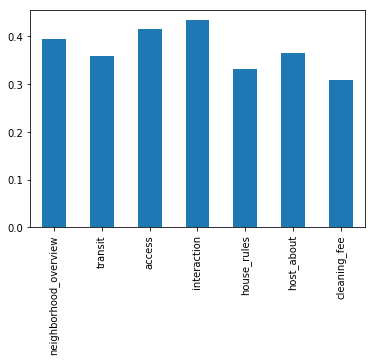

In [685]:
df_listing_modi2_missing = df_listing_modi2.isna().mean()
df_listing_modi2_missing[df_listing_modi2_missing>0.3].plot.bar()

In [686]:
df_listing_modi2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 79 columns):
id                                  3585 non-null int64
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
host_id                             3585 non-null int64
host_name                           3585 non-null object
host_since                          3585 non-null object
host_location                       3574 non-null object
host_about                          2276

In [687]:
name_columns = list(df_listing_modi2.columns)
# print(name_columns)
type_columns = list(df_listing_modi2.dtypes)
name_type =dict(zip(name_columns, type_columns))
print(name_type)

{'id': dtype('int64'), 'name': dtype('O'), 'summary': dtype('O'), 'space': dtype('O'), 'description': dtype('O'), 'experiences_offered': dtype('O'), 'neighborhood_overview': dtype('O'), 'transit': dtype('O'), 'access': dtype('O'), 'interaction': dtype('O'), 'house_rules': dtype('O'), 'host_id': dtype('int64'), 'host_name': dtype('O'), 'host_since': dtype('O'), 'host_location': dtype('O'), 'host_about': dtype('O'), 'host_response_time': dtype('O'), 'host_response_rate': dtype('O'), 'host_acceptance_rate': dtype('O'), 'host_is_superhost': dtype('O'), 'host_neighbourhood': dtype('O'), 'host_listings_count': dtype('int64'), 'host_total_listings_count': dtype('int64'), 'host_verifications': dtype('O'), 'host_has_profile_pic': dtype('O'), 'host_identity_verified': dtype('O'), 'street': dtype('O'), 'neighbourhood': dtype('O'), 'neighbourhood_cleansed': dtype('O'), 'city': dtype('O'), 'state': dtype('O'), 'zipcode': dtype('O'), 'market': dtype('O'), 'smart_location': dtype('O'), 'latitude': dt

In [688]:
# Show object columns
tmp = df_listing_modi2.columns.to_list()
tmp1 = df_listing_modi2.dtypes.to_list()
columns_of_object = []

for i,j in zip(tmp,tmp1):
    if j == object:
        print(len(df_listing_modi2[i].value_counts()),"  ", j,"  ", i)
        columns_of_object.append(i)
print()
print(columns_of_object)
    

3504    object    name
3113    object    summary
2268    object    space
3423    object    description
1    object    experiences_offered
1728    object    neighborhood_overview
1859    object    transit
1762    object    access
1617    object    interaction
1928    object    house_rules
1334    object    host_name
1281    object    host_since
176    object    host_location
1240    object    host_about
4    object    host_response_time
52    object    host_response_rate
72    object    host_acceptance_rate
2    object    host_is_superhost
53    object    host_neighbourhood
83    object    host_verifications
2    object    host_has_profile_pic
2    object    host_identity_verified
1239    object    street
30    object    neighbourhood
25    object    neighbourhood_cleansed
38    object    city
1    object    state
43    object    zipcode
4    object    market
39    object    smart_location
2    object    is_location_exact
13    object    property_type
3    object    room_type
5    objec

In [689]:
df_listing_modi2[columns_of_object].head(n=3)

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,access,interaction,house_rules,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,is_location_exact,property_type,room_type,bed_type,amenities,price,cleaning_fee,extra_people,calendar_updated,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...","The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,Roslindale,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,MA,02131,Boston,"Boston, MA",t,House,Entire home/apt,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,$35.00,$0.00,2 weeks ago,2016-09-06,NaN,NaN,f,f,moderate,f,f
1,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,Roslindale,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,MA,02131,Boston,"Boston, MA",t,Apartment,Private room,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00,$10.00,$0.00,a week ago,2016-09-06,2014-06-01,2016-08-13,f,t,moderate,f,f
2,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,"PUBLIC TRANSPORTATION: From the house, quick p...","I am living in the apartment during your stay,...","ABOUT ME: I'm a laid-back, friendly, unmarried...","I encourage you to use my kitchen, cooking and...",Phil,2009-05-11,"Boston, Massachusetts, United States","I am a middle-aged, single male with a wide ra...",within a few hours,100%,88%,t,Roslindale,"['email', 'phone', 'reviews', 'jumio']",t,t,"Ardale St., Boston, MA 02131, United States",Roslindale,Roslindale,Boston,MA,02131,Boston,"Boston, MA",t,Apartment,Private room,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",$65.00,NaN,$20.00,5 days ago,2016-09-06,2009-07-19,2016-08-05,f,f,moderate,t,f


In [690]:
# Overlap : [city, smart_location]
print(len(df_listing_modi2.city.unique()))
print("**"*30)
print(len(df_listing_modi2.smart_location.unique()))

# Only one : [state]
print("**"*30)
print(df_listing_modi2.state.unique())

# Wrong data : [market, calendar_last_scraped]
print("**"*30)
print(df_listing_modi2.market.value_counts())

#
print("**"*30)
print(df_listing_modi2.neighbourhood_cleansed.value_counts())
print("**"*30)
print(df_listing_modi2.neighbourhood.value_counts())

39
************************************************************
39
************************************************************
['MA']
************************************************************
Boston                   3568
San Francisco               1
Other (International)       1
Other (Domestic)            1
Name: market, dtype: int64
************************************************************
Jamaica Plain              343
South End                  326
Back Bay                   302
Fenway                     290
Dorchester                 269
Allston                    260
Beacon Hill                194
Brighton                   185
South Boston               174
Downtown                   172
East Boston                150
Roxbury                    144
North End                  143
Mission Hill               124
Charlestown                111
South Boston Waterfront     83
Chinatown                   71
Roslindale                  56
West End                    49
West Ro

In [691]:
remove_list2 = ['smart_location', 'state', 'name', 'summary', 'space', 'description','neighborhood_overview',
                'transit','access','market','calendar_last_scraped']
df_listing_modi3 = df_listing_modi2.drop(remove_list2, axis=1)
df_listing_modi3.shape

(3585, 68)

In [692]:
# column house_rules was changed to a boolean columns that there are rules or not

In [693]:
df_listing_modi3.house_rules.notna().value_counts()

True     2393
False    1192
Name: house_rules, dtype: int64

In [694]:
df_listing_modi3['house_rules_exist_tf']= pd.notna(df_listing_modi3.house_rules)

In [695]:
df_listing_modi3 = df_listing_modi3.drop(['house_rules'], axis=1)
df_listing_modi3.head()

,id,experiences_offered,interaction,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday,house_rules_exist_tf
0,12147973,none,NaN,31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,02131,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,$35.00,1,$0.00,2,1125,2 weeks ago,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,moderate,f,f,1,NaN,365.0,0.0,0.0,NaN,NaN,True
1,3075044,none,"If I am at home, I am likely working in my hom...",2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,02131,42.286241,-71.134374,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00,$10.00,0,$0.00,2,15,a week ago,26,54,84,359,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,t,moderate,f,f,1,1.30,6.0,101.0,258.0,75.0,65.0,True
2,6976,none,"ABOUT ME: I'm a laid-back, friendly, unmarried...",16701,Phil,2009-05-11,"Boston, Massachusetts, United States","I am a middle-aged, single male with a wide ra...",within a few hours,100%,88%,t,Roslindale,1,1,"['email', 'phone', 'reviews', 'jumio']",t,t,"Ardale St., Boston, MA 02131, United States",Roslindale,Roslindale,Boston,02131,42.292438,-71.135765,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",$65.00,NaN,1,$20.00,3,45,5 days ago,19,46,61,319,41,2009-07-19,2016-08-05,98.0,10.0,9.0,10.0,10.0,9.0,10.0,f,f,moderate,t,f,1,0.47,46.0,91.0,228.0,65.0,65.0,True
3,1436513,none,We do live in the house therefore might be som...,6031442,Meghna,2013-04-21,"Boston, Massachusetts, United States",My husband and I live on the property. He’s a...,within a few hours,100%,50%,f,NaN,1,1,"['email', 'phone', 'reviews']",t,f,"Boston, MA, United States",NaN,Roslindale,Boston,NaN,42.281106,-71.121021,f,House,Private room,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$75.00,$50.00,2,$25.00,1,1125,a week ago,6,16,26,98,1,2016-08-28,2016-08-28,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,moderate,f,f,1,1.00,267.0,66.0,32.0,75.0,75.0,True
4,7651065,none,I love my city and really enjoy sharing it wit...,15396970,Linda,2014-05-11,"Boston, Massachusetts, United States",I work full time for a public school district....,within an hour,100%,100%,t,Roslindale,1,1,"['email', 'phone', 'reviews', 'kba']",t,t,"Durnell Avenue, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,02131,42.284512,-71.136258,t,House,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,""Wireless Internet"",""Air 

In [696]:
print(df_listing_modi3.neighbourhood.unique())
df_listing_modi3.head()

['Roslindale' nan 'Jamaica Plain' 'Mission Hill' 'Fenway/Kenmore'
 'Back Bay' 'Leather District' 'Chinatown' 'Hyde Park' 'North End'
 'Roxbury' 'South End' 'Mattapan' 'East Boston' 'South Boston'
 'Charlestown' 'West End' 'Beacon Hill' 'Theater District'
 'Downtown Crossing' 'Downtown' 'Financial District' 'Government Center'
 'Allston-Brighton' 'West Roxbury' 'Chestnut Hill' 'Dorchester'
 'Brookline' 'Cambridge' 'Somerville' 'Harvard Square']


,id,experiences_offered,interaction,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday,house_rules_exist_tf
0,12147973,none,NaN,31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,02131,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,$35.00,1,$0.00,2,1125,2 weeks ago,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,moderate,f,f,1,NaN,365.0,0.0,0.0,NaN,NaN,True
1,3075044,none,"If I am at home, I am likely working in my hom...",2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,02131,42.286241,-71.134374,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$65.00,$10.00,0,$0.00,2,15,a week ago,26,54,84,359,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,t,moderate,f,f,1,1.30,6.0,101.0,258.0,75.0,65.0,True
2,6976,none,"ABOUT ME: I'm a laid-back, friendly, unmarried...",16701,Phil,2009-05-11,"Boston, Massachusetts, United States","I am a middle-aged, single male with a wide ra...",within a few hours,100%,88%,t,Roslindale,1,1,"['email', 'phone', 'reviews', 'jumio']",t,t,"Ardale St., Boston, MA 02131, United States",Roslindale,Roslindale,Boston,02131,42.292438,-71.135765,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",$65.00,NaN,1,$20.00,3,45,5 days ago,19,46,61,319,41,2009-07-19,2016-08-05,98.0,10.0,9.0,10.0,10.0,9.0,10.0,f,f,moderate,t,f,1,0.47,46.0,91.0,228.0,65.0,65.0,True
3,1436513,none,We do live in the house therefore might be som...,6031442,Meghna,2013-04-21,"Boston, Massachusetts, United States",My husband and I live on the property. He’s a...,within a few hours,100%,50%,f,NaN,1,1,"['email', 'phone', 'reviews']",t,f,"Boston, MA, United States",NaN,Roslindale,Boston,NaN,42.281106,-71.121021,f,House,Private room,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",$75.00,$50.00,2,$25.00,1,1125,a week ago,6,16,26,98,1,2016-08-28,2016-08-28,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,moderate,f,f,1,1.00,267.0,66.0,32.0,75.0,75.0,True
4,7651065,none,I love my city and really enjoy sharing it wit...,15396970,Linda,2014-05-11,"Boston, Massachusetts, United States",I work full time for a public school district....,within an hour,100%,100%,t,Roslindale,1,1,"['email', 'phone', 'reviews', 'kba']",t,t,"Durnell Avenue, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,02131,42.284512,-71.136258,t,House,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,""Wireless Internet"",""Air 

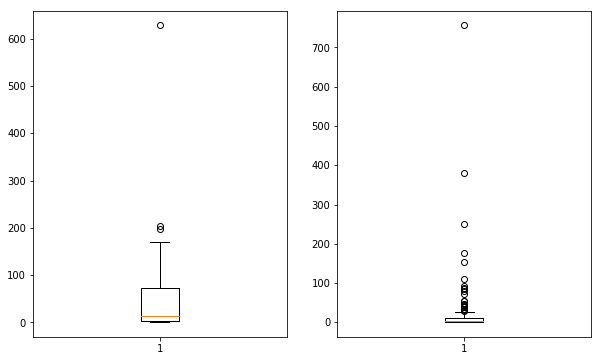

100.0    628
93.0     205
96.0     197
95.0     171
97.0     168
90.0     163
80.0     160
98.0     153
94.0     109
92.0     105
91.0      88
87.0      87
88.0      69
99.0      65
89.0      56
86.0      47
85.0      39
84.0      34
60.0      33
83.0      30
70.0      19
82.0      16
75.0      16
73.0      14
78.0      12
40.0      11
79.0      10
77.0       9
76.0       7
81.0       7
20.0       6
64.0       5
74.0       5
67.0       4
71.0       4
50.0       3
65.0       3
68.0       2
47.0       2
66.0       2
48.0       1
72.0       1
53.0       1
58.0       1
69.0       1
55.0       1
62.0       1
46.0       1
Name: review_scores_rating, dtype: int64

In [697]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.boxplot(df_listing_modi3.review_scores_rating.value_counts())

plt.subplot(122)
plt.boxplot(df_listing_modi3.number_of_reviews.value_counts())
plt.show()

df_listing_modi3.review_scores_rating.value_counts()

In [698]:
# df_listing_modi3['integrated_score'] = df_listing_modi3['review_scores_rating']*df_listing_modi3['number_of_reviews']
# df_listing_modi3['integrated_score_log'] = np.log(df_listing_modi3['integrated_score'] )
# df_listing_modi3.head()

In [699]:
# print(df_listing_modi3.integrated_score_log.value_counts().sort_index())
# plt.scatter(df_listing_modi3.integrated_score_log.value_counts().sort_index().index, df_listing_modi3.integrated_score_log.value_counts().sort_index().values)

AttributeError: 'DataFrame' object has no attribute 'integrated_score_log'

In [ ]:
print(df_listing_modi3.integrated_score_log.quantile(0.1))
print(df_listing_modi3.integrated_score_log.quantile(0.9))

In [ ]:
df_listing_modi3.info()

In [ ]:
tmp = df_listing_modi3.columns.to_list()
tmp1 = df_listing_modi3.dtypes.to_list()
columns_of_object = []

for i,j in zip(tmp,tmp1):
    if j == object and len(df_listing_modi3[i].value_counts()) > 1000:
        print(len(df_listing_modi3[i].value_counts()),"  ", j,"  ", i)
        columns_of_object.append(i)
print()
print(columns_of_object)

In [ ]:
# Remove columns having 1000 unique string valuses and irrelevant data
df_listing_modi3.tail(n=2)
remove_list3 = ['interaction', 'host_name', 'host_since', 'host_about', 'street','first_review','last_review','host_location','neighbourhood_cleansed']
df_listing_modi4 = df_listing_modi3.drop(remove_list3, axis=1)
# Remove columns having 1 unique value
df_listing_modi4 = df_listing_modi4.drop(['experiences_offered','requires_license'], axis=1)

In [ ]:
tmp = df_listing_modi4.columns.to_list()
tmp1 = df_listing_modi4.dtypes.to_list()
columns_of_object = []

for i,j in zip(tmp,tmp1):
    if j == object and len(df_listing_modi4[i].value_counts()) > 10 :
        print(len(df_listing_modi4[i].value_counts()),"  ", j,"  ", i)
        columns_of_object.append(i)
print()
print(columns_of_object)


In [ ]:
# Change the columns 'host_response_rate', 'host_acceptance_rate' to float type
df_listing_modi4.host_response_rate.unique()
df_listing_modi4['host_response_rate']= df_listing_modi4['host_response_rate'].str.replace('%','')
df_listing_modi4['host_response_rate']=df_listing_modi4['host_response_rate'].str.replace(',','')
df_listing_modi4['host_response_rate'] = df_listing_modi4['host_response_rate'].astype(float)
# print(df_listing_modi4.host_response_rate.unique())

df_listing_modi4.host_acceptance_rate.unique()
df_listing_modi4['host_acceptance_rate']= df_listing_modi4['host_acceptance_rate'].str.replace('%','')
df_listing_modi4['host_acceptance_rate']=df_listing_modi4['host_acceptance_rate'].str.replace(',','')
df_listing_modi4['host_acceptance_rate'] = df_listing_modi4['host_acceptance_rate'].astype(float)
# print(df_listing_modi4.host_acceptance_rate.unique())
df_listing_modi4.host_acceptance_rate.dtype

df_listing_modi4.price.unique()
df_listing_modi4['price']= df_listing_modi4['price'].str.replace('$','')
df_listing_modi4['price']=df_listing_modi4['price'].str.replace(',','')
df_listing_modi4['price'] = df_listing_modi4['price'].astype(float)
df_listing_modi4.price.unique()

df_listing_modi4.cleaning_fee.unique()
df_listing_modi4['cleaning_fee']= df_listing_modi4['cleaning_fee'].str.replace('$','')
df_listing_modi4['cleaning_fee']=df_listing_modi4['cleaning_fee'].str.replace(',','')
df_listing_modi4['cleaning_fee'] = df_listing_modi4['cleaning_fee'].astype(float)
df_listing_modi4.cleaning_fee.unique()

df_listing_modi4.extra_people.unique()

In [ ]:
df_listing_modi4.amenities = df_listing_modi4.amenities.str.replace("[{}]", "")
print(df_listing_modi4.amenities.head(n=2))
df_amenities = df_listing_modi4.amenities.str.get_dummies(sep = ",")
df_amenities = df_amenities.add_prefix('amenities_')
df_amenities.head(n=3)
df_amenities.shape
print(df_listing_modi4.shape)
df_listing_modi4 = pd.concat([df_listing_modi4, df_amenities], axis=1)
print(df_listing_modi4.shape)
df_listing_modi5 = df_listing_modi4.drop('amenities', axis=1)
print(df_listing_modi5.shape)

In [ ]:
tmp = df_listing_modi5.columns.to_list()
tmp1 = df_listing_modi5.dtypes.to_list()
columns_of_object = []
columns_of_object_less10 =[]

for i,j in zip(tmp,tmp1):
    if j == object and len(df_listing_modi5[i].value_counts()) < 10 :
        print(len(df_listing_modi5[i].value_counts()),"  ", j,"  ", i)
        columns_of_object.append(i)
        columns_of_object_less10.append(i)
print()
print(columns_of_object_less10)

In [ ]:
df_listing_modi5 = pd.get_dummies(df_listing_modi5, columns=columns_of_object_less10, prefix=columns_of_object_less10, dummy_na=True)
print(df_listing_modi5.shape)

# df_listing_modi5 = df_listing_modi5.drop(columns=columns_of_object_less10, axis=1)
# print(df_listing_modi5.shape)
# df_listing_modi5 = df_listing_modi4.drop('amenities', axis=1)
# azdias_under12_onehot2 = pd.get_dummies(azdias_under12_onehot1, columns=['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 
#                                                                          'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 
#                                                                           'GEBAEUDETYP', 'CAMEO_DEUG_2015' ], 
#                                         prefix = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'NATIONALITAET_KZ', 
#                                                   'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015'])

In [ ]:
df_listing_modi5.head()

In [ ]:
df_listing_modi5.info()

In [ ]:
tmp = df_listing_modi5.columns.to_list()
tmp1 = df_listing_modi5.dtypes.to_list()
columns_of_object = []
columns_of_object_over10 =[]

for i,j in zip(tmp,tmp1):
    if j == object and len(df_listing_modi5[i].value_counts()) > 10 :
        print(len(df_listing_modi5[i].value_counts()),"  ", j,"  ", i)
        columns_of_object.append(i)
        columns_of_object_over10.append(i)
print()
print(columns_of_object_over10)

In [ ]:
df_listing_modi5['extra_people'] = df_listing_modi5['extra_people'].astype(str)
df_listing_modi5['extra_people']= df_listing_modi5['extra_people'].str.replace('$','')
df_listing_modi5['extra_people']=df_listing_modi5['extra_people'].str.replace(',','')
df_listing_modi5['extra_people'] = df_listing_modi5['extra_people'].astype(float)
df_listing_modi5['extra_people'] = df_listing_modi5['extra_people'].replace(to_replace=0, value=np.nan)
df_listing_modi5.extra_people.unique()
df_listing_modi5.extra_people.value_counts(dropna=False)
# df_listing_modi5[] = df_listing_modi5.cleaning_fee.isna().value_counts()

In [ ]:
df_listing_modi5['extra_people_fee_tf']= pd.notna(df_listing_modi5.extra_people)
df_listing_modi5[['extra_people_fee_tf','extra_people']].head()

In [ ]:
df_listing_modi5 = df_listing_modi5.drop('extra_people', axis=1)

In [ ]:
tmp = df_listing_modi5.columns.to_list()
tmp1 = df_listing_modi5.dtypes.to_list()
columns_of_object = []
columns_of_object_over10 =[]

for i,j in zip(tmp,tmp1):
    if j == object and len(df_listing_modi5[i].value_counts()) > 10 :
        print(len(df_listing_modi5[i].value_counts()),"  ", j,"  ", i)
        columns_of_object.append(i)
        columns_of_object_over10.append(i)
print()
print(columns_of_object_over10)

In [ ]:
df_listing_modi5.host_verifications.unique()

In [ ]:
df_listing_modi5.host_verifications = df_listing_modi5.host_verifications.str.replace("[", "")
df_listing_modi5.host_verifications = df_listing_modi5.host_verifications.str.replace("]", "")
df_host_verifications = df_listing_modi5.host_verifications.str.get_dummies(sep = ",")
df_host_verifications = host_verifications.add_prefix('host_verification_')
df_host_verifications.shape
df_host_verifications
print(df_listing_modi5.shape)
df_listing_modi5 = pd.concat([df_listing_modi5, df_host_verifications], axis=1)
print(df_listing_modi5.shape)
df_listing_modi5 =  df_listing_modi5.drop(['host_verifications'], axis=1)

# df_listing_modi4.amenities = df_listing_modi4.amenities.str.replace("[{}]", "")
# print(df_listing_modi4.amenities.head(n=2))
# df_amenities = df_listing_modi4.amenities.str.get_dummies(sep = ",")
# df_amenities = df_amenities.add_prefix('amenities_')
# df_amenities.head(n=3)
# df_amenities.shape
# print(df_listing_modi4.shape)
# df_listing_modi4 = pd.concat([df_listing_modi4, df_amenities], axis=1)
# print(df_listing_modi4.shape)
# df_listing_modi5 = df_listing_modi4.drop('amenities', axis=1)
# print(df_listing_modi5.shape)

In [ ]:
tmp = df_listing_modi5.columns.to_list()
tmp1 = df_listing_modi5.dtypes.to_list()
columns_of_object = []
columns_of_object_over10 =[]

for i,j in zip(tmp,tmp1):
    if j == object and len(df_listing_modi5[i].value_counts()) > 10 :
        print(len(df_listing_modi5[i].value_counts()),"  ", j,"  ", i)
        columns_of_object.append(i)
        columns_of_object_over10.append(i)
print()
print(columns_of_object_over10)

In [ ]:
df_listing_modi5 =  df_listing_modi5.drop(['host_neighbourhood'], axis=1)

In [ ]:
print(df_listing_modi5.calendar_updated.unique())
df_listing_modi5.calendar_updated.value_counts()

In [ ]:
df_listing_modi5["calendar_updated_1weekago"] = np.where(df_listing_modi5['calendar_updated'].str.contains("days|yesterday|today|a week ago")==True,
                                                         'yes', 'more_than_1week')


In [ ]:
df_listing_modi5 =  df_listing_modi5.drop(['calendar_updated'], axis=1)

In [ ]:
tmp = df_listing_modi5.columns.to_list()
tmp1 = df_listing_modi5.dtypes.to_list()
columns_of_object = []
columns_of_object_over10 =[]

for i,j in zip(tmp,tmp1):
    if j == object and len(df_listing_modi5[i].value_counts()) > 10 :
        print(len(df_listing_modi5[i].value_counts()),"  ", j,"  ", i)
        columns_of_object.append(i)
        columns_of_object_over10.append(i)
print()
print(columns_of_object_over10)

In [ ]:
df_listing_modi5 = pd.get_dummies(df_listing_modi5, columns=columns_of_object_over10, prefix=columns_of_object_over10, dummy_na=True)

In [ ]:
df_listing_modi5.shape
df_listing_modi5.info()

In [ ]:
tmp = df_listing_modi5.columns.to_list()
tmp1 = df_listing_modi5.dtypes.to_list()
columns_of_object = []
columns_of_object_over10 =[]

for i,j in zip(tmp,tmp1):
    if j == object :
        print(len(df_listing_modi5[i].value_counts()),"  ", j,"  ", i)
        columns_of_object.append(i)
        columns_of_object_over10.append(i)
print()
print(columns_of_object_over10)

In [ ]:
df_listing_modi5 = pd.get_dummies(df_listing_modi5, columns=['calendar_updated_1weekago','house_rules_exist_tf','extra_people_fee_tf'], 
                                  prefix=['calendar_updated_1weekago','house_rules_exist_tf','extra_people_fee_tf'], dummy_na=True)

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_listing_modi5.isnull(), cbar=False)

In [ ]:
df_listing_modi5.columns[df_listing_modi5.isna().any()].tolist()

In [ ]:
df_listing_modi5[["host_response_rate",'host_acceptance_rate']].head(n=5)
print(df_listing_modi5.host_response_rate.value_counts())
print(df_listing_modi5.host_acceptance_rate.value_counts())
df_listing_modi5["host_response_rate_100"] = np.where(df_listing_modi5['host_response_rate'] ==100, True, False)
df_listing_modi5["host_acceptance_rate_100"] = np.where(df_listing_modi5['host_acceptance_rate'] ==100, True, False)


In [ ]:
df_listing_modi5[["host_response_rate_100",'host_acceptance_rate_100']]
df_listing_modi5 =  df_listing_modi5.drop(['host_response_rate','host_acceptance_rate','reviews_per_month'], axis=1)

In [ ]:
tmp = df_listing_modi5.columns[df_listing_modi5.isna().any()].tolist()
tmp
df_listing_modi5[tmp].isnull().astype(int).sum()

In [702]:
#bathrooms, bedrooms, beds, cleaning_fee, review_scores_rating, review_... : : fillna with mean value
columns1 = ['bathrooms','bedrooms','beds','cleaning_fee','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
            'review_scores_communication','review_scores_location','review_scores_value']
df_listing_modi5[columns1] = df_listing_modi5[columns1].fillna(df_listing_modi5.mean())
df_listing_modi5.price_weekend.fillna(df_listing_modi5.price, inplace=True)
df_listing_modi5.price_weekday.fillna(df_listing_modi5.price, inplace=True)


# r fillna with mean value
# 위 진행후 아래 진행
    ## df_listing_modi3['integrated_score'] = df_listing_modi3['review_scores_rating']*df_listing_modi3['number_of_reviews']
    ## df_listing_modi3['integrated_score_log'] = np.log(df_listing_modi3['integrated_score'] )
    ## df_listing_modi3.head()

# df_listing_modi5.review_scores_rating.value_counts(dropna=False)
df_listing_modi5['integrated_score_log'] = np.log(df_listing_modi5['review_scores_rating']*df_listing_modi5['number_of_reviews'])
df_listing_modi5.head()


tmp = df_listing_modi5.columns[df_listing_modi5.isna().any()].tolist()
tmp
df_listing_modi5[tmp].isnull().astype(int).sum()

/Users/dalpengholic/anaconda3/envs/nbastat1/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


integrated_score    813
dtype: int64

In [ ]:
# df_listing_modi5[df_listing_modi5['review_scores_rating'].isnull()]

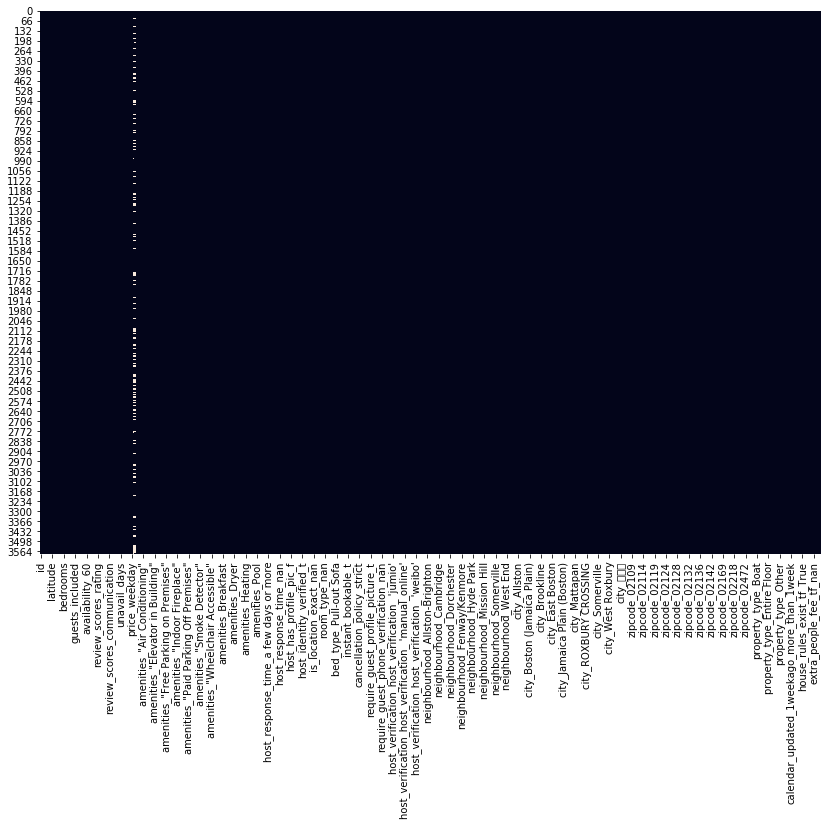

In [701]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_listing_modi5.isnull(), cbar=False)